In [3]:
%%capture
%pip install nfl_data_py --upgrade

In [4]:
import nfl_data_py as nfl
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import pyplot as plt

import warnings; warnings.simplefilter('ignore');

In [5]:
weekly_df = nfl.import_weekly_data(years=range(2000,2023))
weekly_df.head()

Downcasting floats.


,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
0,00-0000003,None,Abdul-Karim al-Jabbar,RB,RB,None,IND,2000,1,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,-0.2,-0.2
1,00-0000007,None,Rabih Abdullah,RB,RB,None,TB,2000,1,REG,...,0.0,-0.312120,0,0.0,0.045455,0.0,0.0,0.0,0.3,1.3
2,00-0000007,None,Rabih Abdullah,RB,RB,None,TB,2000,12,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,1.8,1.8
3,00-0000007,None,Rabih Abdullah,RB,RB,None,TB,2000,14,REG,...,1.0,0.609493,0,0.0,0.071429,0.0,0.0,0.0,4.9,5.9
4,00-0000007,None,Rabih Abdullah,RB,RB,None,TB,2000,15,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,1.4,1.4


In [6]:
weekly_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119053 entries, 0 to 5628
Data columns (total 52 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   player_id                    119053 non-null  object 
 1   player_name                  55848 non-null   object 
 2   player_display_name          119053 non-null  object 
 3   position                     118984 non-null  object 
 4   position_group               118984 non-null  object 
 5   headshot_url                 64136 non-null   object 
 6   recent_team                  119053 non-null  object 
 7   season                       119053 non-null  int32  
 8   week                         119053 non-null  int32  
 9   season_type                  119053 non-null  object 
 10  completions                  119053 non-null  int32  
 11  attempts                     119053 non-null  int32  
 12  passing_yards                119053 non-null  float32
 13  p

In [9]:
eligible_positions=['WR','RB','QB']
grouping_columns=['player_id', 'season']
features=['targets','receptions','rushing_yards','receiving_yards','passing_yards','passing_tds']
target=['position']

# we will use this data to create a preditive model of a player's position
train_df = weekly_df.loc[weekly_df['position'].isin(eligible_positions), grouping_columns + features + target]

groupby_funcs = {
    'position': 'first'
}

for feature in features:
  groupby_funcs[feature] = np.sum

train_df = train_df.groupby(grouping_columns, as_index=False).agg(groupby_funcs)

train_df.head()

,player_id,season,position,targets,receptions,rushing_yards,receiving_yards,passing_yards,passing_tds
0,00-0000003,2000,RB,0,0,-2.0,0.0,0.0,0
1,00-0000007,2000,RB,2,2,70.0,14.0,0.0,0
2,00-0000007,2001,RB,2,2,40.0,26.0,0.0,0
3,00-0000007,2003,RB,9,8,37.0,55.0,0.0,0
4,00-0000007,2004,RB,2,1,13.0,9.0,0.0,0


In [10]:
train_df['position'].unique()

array(['RB', 'QB', 'WR'], dtype=object)

In [11]:
train_df['position'] = train_df['position'].replace({
    'RB':0,
    'WR':1,
    'QB':2
})

# filter out data which may skew (players with low yardage or did not have much play time)
train_df_filtered = train_df.loc[(train_df['rushing_yards'] > 200) | (train_df['passing_yards'] > 300) | (train_df['receiving_yards'] > 150)]

In [12]:
train_df_filtered.head()

,player_id,season,position,targets,receptions,rushing_yards,receiving_yards,passing_yards,passing_tds
5,00-0000104,2000,2,0,0,13.0,0.0,1616.0,7
6,00-0000145,2000,1,134,72,45.0,1265.0,0.0,0
7,00-0000145,2001,1,68,27,16.0,470.0,0.0,0
9,00-0000210,2000,0,60,39,1106.0,291.0,0.0,0
10,00-0000210,2001,0,45,31,476.0,212.0,0.0,0


In [16]:
train_df_filtered['position'].unique()

array([2, 1, 0])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df_filtered[features],
    train_df_filtered[target],
    test_size=0.2,
    random_state=123
)

X_train

,targets,receptions,rushing_yards,receiving_yards,passing_yards,passing_tds
8511,109,72,9.0,786.0,39.0,1
4592,38,24,0.0,248.0,0.0,0
6191,76,37,0.0,371.0,0.0,0
8398,2,2,741.0,20.0,0.0,0
7327,60,46,591.0,250.0,0.0,0
...,...,...,...,...,...,...
8487,52,28,0.0,297.0,0.0,0
6510,60,36,17.0,408.0,0.0,0
2057,66,43,-8.0,593.0,0.0,0
5543,8,5,416.0,30.0,0.0,0


In [22]:
# max levels a tree can have
clf = DecisionTreeClassifier(max_depth=2)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


# y test is our "true" data
accuracy_score(y_test, y_pred)

0.9825174825174825

[Text(0.5, 0.8333333333333334, 'rushing_yards <= 116.5\ngini = 0.624\nsamples = 4573\nvalue = [1362, 2257, 954]\nclass = WR'),
 Text(0.25, 0.5, 'receptions <= 4.0\ngini = 0.366\nsamples = 2896\nvalue = [57, 2222, 617]\nclass = WR'),
 Text(0.125, 0.16666666666666666, 'gini = 0.0\nsamples = 616\nvalue = [0, 0, 616]\nclass = QB'),
 Text(0.375, 0.16666666666666666, 'gini = 0.05\nsamples = 2280\nvalue = [57, 2222, 1]\nclass = WR'),
 Text(0.75, 0.5, 'passing_yards <= 57.0\ngini = 0.354\nsamples = 1677\nvalue = [1305, 35, 337]\nclass = RB'),
 Text(0.625, 0.16666666666666666, 'gini = 0.051\nsamples = 1339\nvalue = [1304, 34, 1]\nclass = RB'),
 Text(0.875, 0.16666666666666666, 'gini = 0.012\nsamples = 338\nvalue = [1, 1, 336]\nclass = QB')]

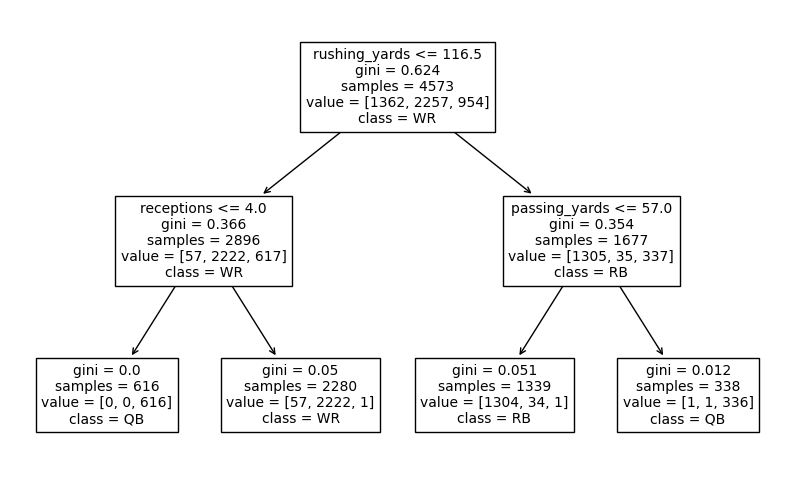

In [23]:
fog, ax = plt.subplots(figsize=(10,6))

class_names = ['RB', 'WR', 'QB']
plot_tree(clf, ax=ax, feature_names=features, class_names = class_names)

In [25]:
# tuning
params = {
    # set max depth
    'max_depth': range(1,10),

    # this will prevent overfitting - minimum amount of samples in order to split a node
    'min_samples_split': range(2,6)
}

# this will help tune our model by walking over our ranges and cross-validate to estimate the performance of each combination of hyperparameters
clf = DecisionTreeClassifier()
# note: k-fold cross validation is a better way to split our data for training and testing
grid_search = GridSearchCV(clf, params, cv=10)
grid_search.fit(
    train_df_filtered[features], train_df_filtered[target]
)



GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 10),
                         'min_samples_split': range(2, 6)})

In [26]:
best_clf = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params

{'max_depth': 5, 'min_samples_split': 2}

In [27]:
best_score

0.9839041431423219

In [28]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.head()

,precision,recall,f1-score,support
0,0.984756,0.961310,0.972892,336.000000
1,0.974790,0.991453,0.983051,585.000000
2,1.000000,0.991031,0.995495,223.000000
accuracy,0.982517,0.982517,0.982517,0.982517
macro avg,0.986515,0.981265,0.983813,1144.000000
